# Qualitative evaluation visualisations
The aim of these visualisations is to evaluate different areas as accurately as possible. This makes it possible to show in which areas the model works well and in which it does not. This also makes it possible to evaluate in which areas the model works better or less well using transfer learning.

In [15]:
import os
current_dir = os.getcwd()
if os.path.basename(current_dir) != 'link-prediction-in-graphs':
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)
print(f"current working directory: {os.getcwd()}")


import torch
from ogb.linkproppred import LinkPropPredDataset
from ogb.nodeproppred import NodePropPredDataset
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics.pairwise import cosine_similarity
# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')
# Set default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18 
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 18

datasets_eda = ['ogbn-arxiv']

dataset = NodePropPredDataset(name=datasets_eda[0])


dataset.name = "Arxiv Computer Science"
dataset_2.name = "Arxiv w/o Computer Science"
def replace_number(number):
    return f"{number:,}".replace(",", "'")

current working directory: /scratch/snx3000/jzwicky/link-prediction-in-graphs
ogbn-papers100M has been updated.


Will you update the dataset now? (y/N)
 N


In [46]:
mrr_list_val = np.load("./evaluation/sample_data_for_evaluation_build/reciprocal_ranks_valid.npy")
source_val = np.load("./evaluation/sample_data_for_evaluation_build/valid_source.npy")
target_val = np.load("./evaluation/sample_data_for_evaluation_build/valid_target.npy")
target_neg_val = np.load("./evaluation/sample_data_for_evaluation_build/valid_target_neg.npy")
pos_pred_val = np.load("./evaluation/sample_data_for_evaluation_build/valid_pos_preds.npy")
neg_pred_val = np.load("./evaluation/sample_data_for_evaluation_build/valid_neg_preds.npy")
target_neg_val= np.array(torch.tensor(target_neg_val).view(-1, 1000))
source_unique_val = np.unique(source_val)

In [47]:
train_edges = np.vstack((np.array([torch.load("./temp/split_edge-ogbn-arxiv.pt")["train"]["source_node"].cpu()]),
                np.array([torch.load("./temp/split_edge-ogbn-arxiv.pt")["train"]["target_node"].cpu()])))
graph, label = dataset[0]
nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(range(graph["node_feat"].shape[0]))
nx_graph.add_edges_from(train_edges.T)

## Quantitative Evaluation

### Reciprocal Rank vs Indegree/ Outdegree/ Clustering Coefficient/ Similarity Outdegree Neighbours
In this section, various comparison variables are compared with the Reciprocal Rank. This is the reverse rank where the positive link was predicted. If it is 1, it means that the positive link has the highest probability. In this section, the goal of the different comparison variables is shown.

#### Indegree:
**Statement of Indegree:** A high Indegree shows that the paper is linked to by many other papers and therefore has a high importance. Since the models are evaluated using newer papers (2018 Validation, 2019 Test), this value is rather low and can also be an indication of how early in the two years the paper was published.

**Hypothesis:** The papers with a higher index score achieve a higher Reciprocal Rank.

**Explanation of the hypothesis:** Papers with a very low index could be unknown papers that were also published in an area in which fewer papers were published. This could mean that their graph structure and Word2vec feature are less known to the model and it therefore makes a less accurate prediction.

#### Outdegree:

**Statement of the outdegree:** The outdegree shows for how many papers the citations are available. If a lot of papers have been cited from other areas (which are not in Arxiv CS), the paper has a deep outdegree.

**Hypothesis:** Papers with a low outdegree achieve a lower Reciprocal Rank.

**Explanation of the hypothesis:** If very few papers have been cited, node embedding tends to learn less from its neighbours. This leads to individual neighbours having a large influence on the prediction. This in turn makes the model unstable, which could lead to a poorer prediction.

#### Clustering coefficient

**Statement of the clustering coefficient:** The clustering coefficient states that its neighbours are closely networked.

**Hypothesis:** If the clustering coefficient is high, a higher Reciprocal Rank is also achieved.

**Explanation of the hypothesis:** It is a little unclear whether this is actually the case. However, if the nodes are more closely interlinked, it could be that the network is more stable. Since it can collect the balanced knowledge of different papers and these in turn are less randomly composed.

#### Similarity Outdegree Neighbours

**Statement of the average Similarity of Outdegree Neighbours:** The Similarity Outdegree Neighbours states how similar the Word2Vec features of the paper's neighbours are to their own Word2Vec features.

**Hypothesis:** The higher the average Similarity of Outdegree Neighbours, the higher the Reciprocal Rank

**Explanation of the hypothesis:** Since the cited papers are similar, it can be assumed that the unknown paper will also be similar. It can be assumed that if the similarity is high, no completely false predictions will be made.

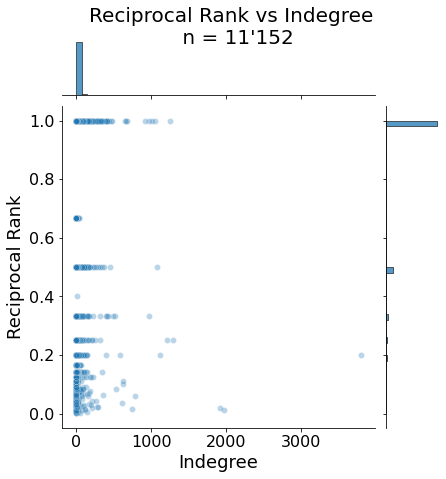

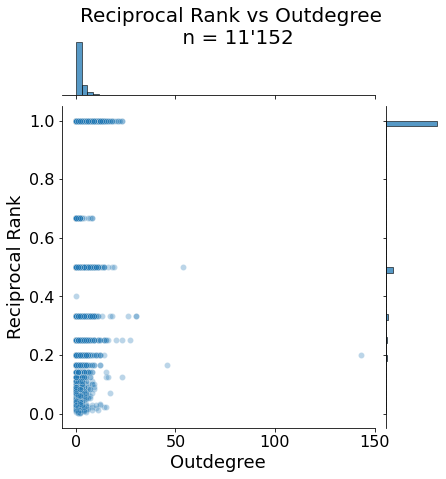

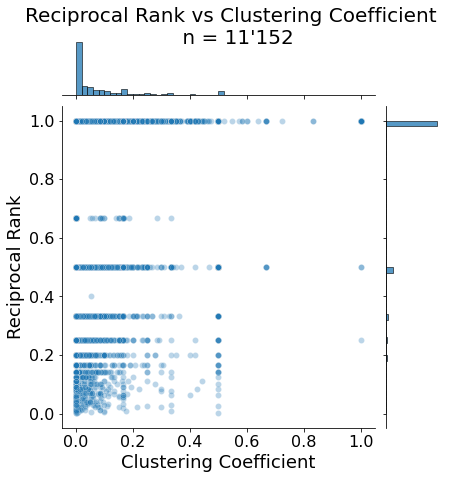

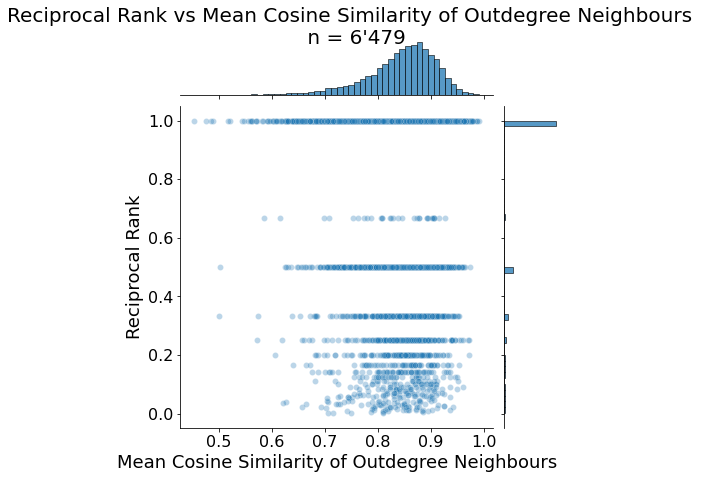

In [27]:
def visualize_in_out_clustering_similarity(mrr_list,nx_graph,evaluation_nodes,validation=True):
    def plot_variable_against_mrr(variable,mrr,variable_name,validation):
        if validation:
            dataset = ""
        else:
            dataset = "Test"
        jp = sns.jointplot(x=variable, y=mrr, kind='scatter', alpha=0.3,marginal_kws={'bins': 50, 'fill': True})
        jp.figure.suptitle(f'{dataset}Reciprocal Rank vs {variable_name} \n n = {replace_number(len(mrr))}',fontsize = 20, y=1.05)
        jp.set_axis_labels(f'{variable_name}', 'Reciprocal Rank')
        plt.savefig(f'{variable_name}.pdf', format='pdf',dpi=5000,bbox_inches='tight')
        plt.show()

    def calculate_similarity_of_neighbours(train_edges,evaluation_nodes,mrr_list):
        adjacency_list = {}

        for source, target in zip(train_edges[0], train_edges[1]):
            if source not in adjacency_list:
                adjacency_list[source] = []
            adjacency_list[source].append(target)
        sub_dict = {key: adjacency_list[key] for key in evaluation_nodes if key in adjacency_list}
        mrr_vs_cosine_similarity = []
        for node in evaluation_nodes:
            if node in adjacency_list:
                mrr_vs_cosine_similarity.append([mrr_list[np.where(node == evaluation_nodes)][0],
                                        cosine_similarity(graph["node_feat"][sub_dict[node]], np.array([graph["node_feat"][node]])).mean()])
                
        return np.array(mrr_vs_cosine_similarity)[:,1],np.array(mrr_vs_cosine_similarity)[:,0]  


    in_degrees = np.array(list(dict(nx_graph.in_degree()).values()))[evaluation_nodes]
    out_degrees = np.array(list(dict(nx_graph.out_degree()).values()))[evaluation_nodes]
    
    clustering_coefficients_for_plotting = [v for (k,v) in nx.clustering(nx_graph,evaluation_nodes).items()]

    similarity,mrr = calculate_similarity_of_neighbours(train_edges,evaluation_nodes,mrr_list)


    plot_variable_against_mrr(in_degrees,mrr_list,"Indegree",validation=validation)
    plot_variable_against_mrr(out_degrees,mrr_list,"Outdegree",validation=validation)
    plot_variable_against_mrr(clustering_coefficients_for_plotting,mrr_list,"Clustering Coefficient",validation=validation)
    plot_variable_against_mrr(similarity,mrr,"Mean Cosine Similarity of Outdegree Neighbours",True)
visualize_in_out_clustering_similarity(mrr_list_val,nx_graph,source_unique_val)

### Nodes of Strong Connected Components

This visualisation is done because we are not fully aware of why there are certain strongly connected components (temporal dependency on referencing among the papers). The aim is to assess whether these components could strongly influence the prediction.

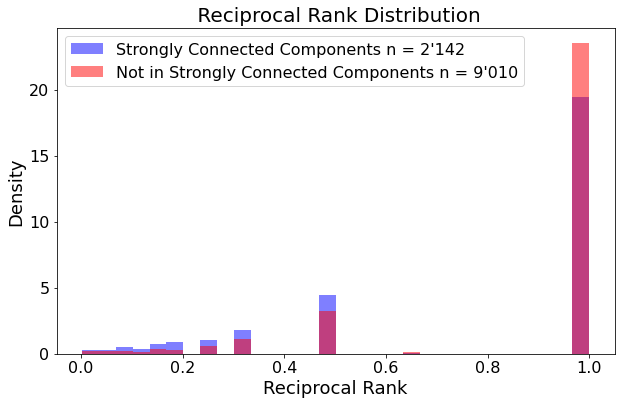

In [48]:
def mrr_distribution_connected_components(nx_graph, evaluation_nodes, validation=True):
    if validation:
        dataset = ""
    else:
        dataset = "Test"
    
    # Identify nodes in strongly connected components (excluding single-node components)
    nodes_in_strong_connected_components = set.union(
        *(set(s) for s in nx.strongly_connected_components(nx_graph) if len(s) != 1)
    )
    nodes_in_strong = [node in nodes_in_strong_connected_components for node in evaluation_nodes]
    
    # Assuming `mrr_list_val` is already defined
    mrr_strong = mrr_list_val[nodes_in_strong]
    mrr_not_strong = mrr_list_val[~np.array(nodes_in_strong)]

    plt.figure(figsize=(10, 6))

    # Define common bins
    bins = np.linspace(min(np.min(mrr_strong), np.min(mrr_not_strong)), 
                       max(np.max(mrr_strong), np.max(mrr_not_strong)), 
                       31)  # 30 bins + 1 edge
    
    # Plot histograms
    plt.hist(mrr_strong, bins=bins, density=True, alpha=0.5, color="blue", label=f'Strongly Connected Components n = {replace_number(len(mrr_strong))}')
    plt.hist(mrr_not_strong, bins=bins, density=True, alpha=0.5, color="red", label=f'Not in Strongly Connected Components n = {replace_number(len(mrr_not_strong))}')
    
    plt.xlabel('Reciprocal Rank')
    plt.ylabel('Density')
    plt.title(f'{dataset} Reciprocal Rank Distribution')
    plt.legend()
    
    plt.savefig('mrr_distribution_connected_components.pdf', format='pdf', dpi=5000, bbox_inches='tight')
    plt.show()

mrr_distribution_connected_components(nx_graph,source_unique_val)

### Visualisation of the Cosine Similarities

**Statement of Cosine Similarities:** The Cosine Similarity shows how similar the Word2Vec features of two nodes are. In this section, the prediction with the highest probability is visualised. This can be either correct or incorrect.

**Why is the visualisation made:** There is a comparability of how the two papers are related. It is still unclear in which area the correct and incorrect predictions lie.

In [44]:
def calc_cosine_similarities_positiv_negativ(pos_pred,neg_pred,target_neg,source_unique,graph,target_val):
    selection_of_positiv = (pos_pred > neg_pred.max(axis=1))

    probability_positive = pos_pred[selection_of_positiv]
    positive_cosine_similarities = [
          cosine_similarity(graph["node_feat"][source].reshape(1, -1),
                            graph["node_feat"][target].reshape(1, -1))[0][0] 
                    for source,target 
                    in zip(source_unique[selection_of_positiv],target_val[selection_of_positiv])]

    probabilities_negative = neg_pred[~selection_of_positiv].max(axis=1)
    negative_cosine_similarities = [cosine_similarity(graph["node_feat"][source].reshape(1, -1),
                                                    graph["node_feat"][target].reshape(1, -1))[0][0] 
                                    for source,target 
                                    in zip(source_unique[~selection_of_positiv],
                                            target_neg[~selection_of_positiv,neg_pred[~selection_of_positiv].argmax(axis=1)])]
    return probability_positive,positive_cosine_similarities, probabilities_negative,negative_cosine_similarities

def visualize_cosine_similarities(positive_cosine_similarities,negative_cosine_similarities,validation=True):
    if validation:
            dataset = ""
    else:
            dataset = "Test"
            
    weights_positive = np.ones_like(positive_cosine_similarities) / len(positive_cosine_similarities)
    weights_negative = np.ones_like(negative_cosine_similarities) / len(negative_cosine_similarities)

    overall_min = min(np.min(positive_cosine_similarities), np.min(negative_cosine_similarities))
    overall_max = max(np.max(positive_cosine_similarities), np.max(negative_cosine_similarities))

    plt.figure(figsize=(10, 6))
    plt.hist(positive_cosine_similarities, bins=50, range=(overall_min, overall_max), weights=weights_positive, alpha=0.5, color="blue", label=f'Correct predicted n = {replace_number(len(positive_cosine_similarities))}')
    plt.hist(negative_cosine_similarities, bins=50, range=(overall_min, overall_max), weights=weights_negative, alpha=0.5, color="red", label=f'Wrong predicted n = {replace_number(len(negative_cosine_similarities))}')
    plt.xlabel('Cosine Similarities')
    plt.ylabel('Density')
    plt.title(f'{dataset}Distribution of Cosine Similarities')
    plt.legend()
    plt.savefig('visualize_cosine_similarities.pdf', format='pdf',dpi=5000,bbox_inches='tight')
    plt.show()

def visualize_proba_vs_cosine_similarity(probability_positive,positive_cosine_similarities, probabilities_negative,negative_cosine_similarities,validation=True):
    if validation:
            dataset = ""
    else:
            dataset = ""
    plt.figure(figsize=(10, 6))
    plt.scatter(probabilities_negative, negative_cosine_similarities, color='red', alpha=0.3, label=f'Wrong predicted n = {replace_number(len(probabilities_negative))}',s = 10)
    plt.scatter(probability_positive, positive_cosine_similarities, color='blue', alpha=0.3, label=f'Correct predicted n = {replace_number(len(probability_positive))}',s = 10)
    plt.title(f'{dataset}Word2vec Similarity of Top1 Predicted Node')
    plt.xlabel('Probability of Prediction')
    plt.ylabel('Cosine Similarities')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualize_proba_vs_cosine_similarity.pdf', format='pdf',dpi=5000,bbox_inches='tight')
    plt.show()

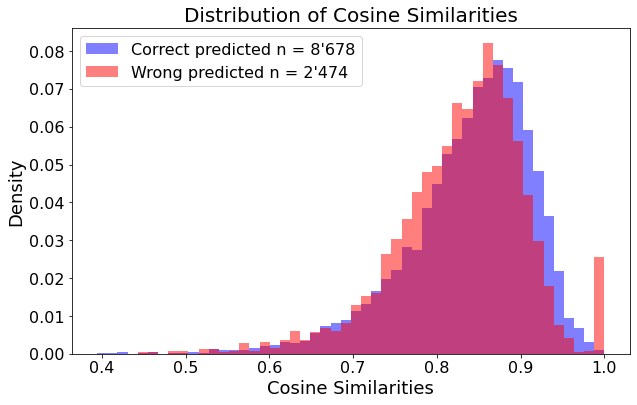

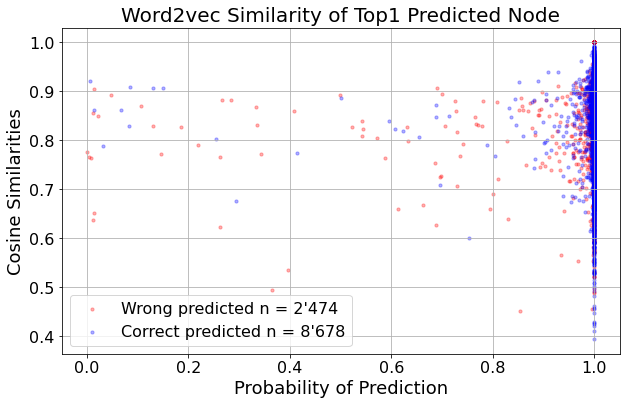

In [45]:
probability_positive,positive_cosine_similarities, probabilities_negative,negative_cosine_similarities = calc_cosine_similarities_positiv_negativ(pos_pred_val,neg_pred_val,target_neg_val,source_unique_val,graph,target_val)
visualize_cosine_similarities(positive_cosine_similarities,negative_cosine_similarities)
visualize_proba_vs_cosine_similarity(probability_positive,positive_cosine_similarities, probabilities_negative,negative_cosine_similarities)

## Qualitative Visualisation - Computational Graph

### What was visualised?
The figure shows various parts. It is first divided into 2 plots, in which everything is calculated and displayed separately. However, the source node is the same.

In the plot **Highest probability wrong prediction** (left), the highest probability is used, which was achieved with the 1000 non-existent selected target nodes. This prediction is explicitly incorrect.

The **Ground Truth Prediction** plot (right) shows the target node for which the real existing link was masked.

In both illustrations, the source node is connected to the target node with a red arrow. This is to show the predicted link.
The 128 dimensions of the Word2vec feature are reduced to 2 dimensions using multidimensional scaling (MDS). The distances represent the similarity of two nodes. The rank of the prediction, the average error of the distances (MDS) and the maximum error of the distances (MDS) of two nodes were displayed above the visualisation.

The feature importance was also calculated for the nodes using the integrated gradient. These are then totalled per node and scaled so that the most important node has an Importance of *1* or *-1*.

### Why was the visualisation done?

The visualisation makes it possible to check various aspects in order to validate them quantitatively at a later date if necessary. The following are individual examples, but the list is not exhaustive:
- Are nodes that are *more* similar to the source node more important for the prediction?
- Is the source node more often in the centre compared to the other nodes?
- Are larger networks more often used as *wrong* predictions with the highest probability?
- How similar do nodes have to be to be important for the prediction?
- Are source and target nodes the most important nodes for the prediction?

In [16]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from torch_geometric.nn import GCNConv
from ogb.linkproppred import Evaluator
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig, ExplainerConfig, Explanation
from torch_geometric.nn import to_captum_input, to_captum_model
from captum.attr import IntegratedGradients, Deconvolution, GuidedBackprop, LRP
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import torch
from captum.attr import IntegratedGradients
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from torch_sparse import SparseTensor


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(
            GCNConv(in_channels, hidden_channels, normalize=False))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, normalize=False))
        self.convs.append(
            GCNConv(hidden_channels, out_channels, normalize=False))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t,edge_weight=None):
        adj_t = adj_t.detach()
        x = self.convs[0](x, adj_t,edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        for conv in self.convs[1:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t,edge_weight)
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)
model = GCN(128, 512, 512, 1, 0)
predictor = LinkPredictor(512, 512, 1,1, 0)

# Load the state dicts back into the models
model.load_state_dict(torch.load('./EDA/sample_data_for_evaluation_build/gcn_model.pth'))
predictor.load_state_dict(torch.load('./EDA/sample_data_for_evaluation_build/link_predictor.pth'))

# Move models to appropriate device, e.g., GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
predictor.to(device)
model.eval()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GCN(
  (convs): ModuleList(
    (0): GCNConv(128, 512)
    (1): GCNConv(512, 512)
  )
)

In [17]:
def select_source_target_nodes(source_node,source_unique,negativ_pred,target_negativ,target_positiv):
    position_selected = np.where(source_node == source_unique)[0][0]
    target_negativ_selected = target_negativ[position_selected][negativ_pred[position_selected].argmax()]
    target_positiv_selected = target_positiv[position_selected]
    return target_negativ_selected,target_positiv_selected,position_selected

def calc_all_nodes(adjacency_list,source_node,target_node,hopp_2:bool):
    nodes_selected = [target_node,source_node] + list(train_edges[1][train_edges[0] == target_node]) + list(train_edges[1][train_edges[0] == source_node])
    if hopp_2:
        nodes_selected = np.unique(np.array(list(itertools.chain.from_iterable([adjacency_list[neighbour] for neighbour in nodes_selected if neighbour in adjacency_list]))  + nodes_selected))
    return np.unique(nodes_selected)


def calc_low_dim_features(graph:dict,nodes_selected:list):
    node_features = graph["node_feat"][nodes_selected]
    high_dim_cosine_distances = pairwise_distances(node_features, metric='cosine')
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    low_dimensional_data = mds.fit_transform(high_dim_cosine_distances)
    low_dim_cosine_distances = pairwise_distances(low_dimensional_data, metric='euclidean')
    nodes_distance = np.abs(low_dim_cosine_distances.ravel() - high_dim_cosine_distances.ravel())
    return low_dimensional_data,nodes_distance.mean(),nodes_distance.max()

def get_neighbours(adj_t,source,target):
    col = adj_t.storage.col()
    row = adj_t.storage.row()


    def find_neighbors(row,col, index):
        neighbors = col[row == index]
        return neighbors

    # Find neighbors of start and target indices
    start_neighbors = find_neighbors(row,col, source)
    target_neighbors = find_neighbors(row,col, target)

    # Find neighbors of neighbors
    start_neighbors_of_neighbors = torch.cat([find_neighbors(row,col, neighbor) for neighbor in start_neighbors])
    target_neighbors_of_neighbors = torch.cat([find_neighbors(row,col, neighbor) for neighbor in target_neighbors])

    # Combine all unique indices to form the new adjacency matrix
    all_indices = torch.unique(torch.cat([torch.tensor([source]), torch.tensor([target]), start_neighbors, target_neighbors, start_neighbors_of_neighbors, target_neighbors_of_neighbors]))
    indices_one_neighbour = torch.unique(torch.cat([torch.tensor([source]), torch.tensor([target]), start_neighbors, target_neighbors]))
    return all_indices,indices_one_neighbour

def create_sparse_tensor(indices,adj_t):
    mask_row = torch.isin(adj_t.storage.row(), indices)
    mask_col = torch.isin(adj_t.storage.col(), indices)
    mask = mask_row & mask_col

    # Filter the rows, columns, and values
    new_row = adj_t.storage.row()[mask]
    new_col = adj_t.storage.col()[mask]
    new_val = adj_t.storage.value()[mask]

    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(np.array(indices))}
    row = [node_mapping[row_value] for row_value in np.array(new_row)]
    col = [node_mapping[col_value] for col_value in np.array(new_col)]
    sparse_tensor_neighbour = SparseTensor(row=torch.tensor(row), col=torch.tensor(col),value=new_val, sparse_sizes=(len(indices), len(indices)))
    return sparse_tensor_neighbour,node_mapping

In [18]:
def calculate_ig_link_predictions(node_mapping,source_node,target,nodes_selected,edges_sparse):
    def model_wrapper(x, edge_index):
        embeddings = model.cpu()(x, edge_index)
        return predictor.cpu()(embeddings[node_mapping[source_node]], embeddings[node_mapping[target]])

    def ig_link_prediction(model, predictor, x_tensor, edge_index):
        model.eval()
        predictor.eval() 
        device = next(model.parameters())

        x_tensor = x_tensor.float()
        edge_index = edge_index

        ig = IntegratedGradients(lambda x: model_wrapper(x, edge_index))

        baseline_x = torch.zeros_like(x_tensor)

        attribute = ig.attribute(inputs=(x_tensor,),
                                baselines=(baseline_x,),
                                target=None,
                                internal_batch_size=len(node_mapping.keys()),
                                return_convergence_delta=True,
                                n_steps=100)

        return attribute

    x_tensor = torch.tensor(graph["node_feat"][nodes_selected], dtype=torch.float)
    edge_index = edges_sparse

    attribute = ig_link_prediction(model, predictor, x_tensor, edge_index)
    node_importances = np.array(attribute[0][0].sum(axis=1))
    return node_importances/ max(node_importances)

In [19]:
def visualize_computational_graph(ax, low_dimensional_data, nodes_selected, edges, source_node, target, average_distance, maximal_distance, mrr_list, position_selected, feature_values,title,node_mapping):

    G = nx.DiGraph()
    for i, pos in enumerate(low_dimensional_data):
        G.add_node(i, pos=pos)
    G.add_edges_from(edges)
    positions = {node: data['pos'] for node, data in G.nodes(data=True)}
    # Normalize feature values for color mapping
    norm = Normalize(vmin=min(feature_values), vmax=max(feature_values))
    cmap = plt.get_cmap('viridis')

    # Draw all nodes with colors based on feature values
    colors = [cmap(norm(value)) for value in feature_values]
    nx.draw(G, pos=positions, node_size=200, node_color=colors, with_labels=False, arrows=True, arrowstyle='-|>', arrowsize=12, ax=ax)

    # Highlight the special edge
    special_edge = (node_mapping[source_node], node_mapping[target])
    nx.draw_networkx_edges(G, pos=positions, edgelist=[special_edge], width=2, edge_color='red', style='dashed', arrows=True, arrowstyle='-|>', arrowsize=12, ax=ax)

    # Create colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Node Importance')


    ax.set_title(title, y=1.15)
    ax.text(0.5, 1.08, f"Rang: {round(1/mrr_list[position_selected])} \n Avg. Distance Mapping Error: {average_distance:.4f} \n Max. Distance Mapping Error: {maximal_distance:.4f} \n Source Node Index: {source_node} \n Target Node Index: {target}", fontsize=14, ha='center', va='center', transform=ax.transAxes)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.grid(True)


In [54]:
def calculate_and_visualize_computational_graph(source_node,graph,mrr_list,adj_t,one_hopp):
    target_negativ_selected,target_positiv_selected,position_selected = select_source_target_nodes(source_node,source_unique_val,neg_pred_val,target_neg_val,target_val)
    
    nodes_selected_negativ,indices_one_neighbour_negativ = get_neighbours(adj_t,source_node,target_negativ_selected)
    nodes_selected_positiv,indices_one_neighbour_positiv = get_neighbours(adj_t,source_node,target_positiv_selected)

    sparse_tensor_negativ,node_mapping_negativ = create_sparse_tensor(nodes_selected_negativ,adj_t)
    sparse_tensor_positiv,node_mapping_positiv = create_sparse_tensor(nodes_selected_positiv,adj_t)


    node_importance_negativ = calculate_ig_link_predictions(node_mapping_negativ,source_node,target_negativ_selected,nodes_selected_negativ,sparse_tensor_negativ)
    node_importance_positiv = calculate_ig_link_predictions(node_mapping_positiv,source_node,target_positiv_selected,nodes_selected_positiv,sparse_tensor_positiv)
    
    if one_hopp:
        index_one_hopp_negativ = [idx in indices_one_neighbour_negativ for idx in nodes_selected_negativ]
        node_importance_negativ = node_importance_negativ[index_one_hopp_negativ]

        index_one_hopp_positiv = [idx in indices_one_neighbour_positiv for idx in nodes_selected_positiv]
        node_importance_positiv = node_importance_positiv[index_one_hopp_positiv]

        sparse_tensor_negativ,node_mapping_negativ = create_sparse_tensor(indices_one_neighbour_negativ,adj_t)
        sparse_tensor_positiv,node_mapping_positiv = create_sparse_tensor(indices_one_neighbour_positiv,adj_t)
        
        nodes_selected_negativ = indices_one_neighbour_negativ
        nodes_selected_positiv = indices_one_neighbour_positiv

    low_dimensional_data_negativ,average_distance_negativ,maximal_distance_negativ = calc_low_dim_features(graph,nodes_selected_negativ)
    low_dimensional_data_positiv,average_distance_positiv,maximal_distance_positiv = calc_low_dim_features(graph,nodes_selected_positiv)


    sparse_tensor_negativ = sparse_tensor_negativ.remove_diag()
    sparse_tensor_positiv= sparse_tensor_positiv.remove_diag()

    fig, axs = plt.subplots(1, 2, figsize=(24, 12)) 
    plt.suptitle('2D Visualization of Nodes',fontsize =28,y = 1.1)



    # Plot negative visualization
    visualize_computational_graph(
        axs[0],
        low_dimensional_data_negativ,
        nodes_selected_negativ,
        np.array(torch.stack([sparse_tensor_negativ.storage.row(),sparse_tensor_negativ.storage.col()])).T,
        source_node,
        target_negativ_selected,
        average_distance_negativ,
        maximal_distance_negativ,
        mrr_list,
        position_selected,
        node_importance_negativ,
        "Highest probability wrong prediction",
        node_mapping_negativ
    )

    # Plot positive visualization
    visualize_computational_graph(
        axs[1],
        low_dimensional_data_positiv,
        nodes_selected_positiv,
        np.array(torch.stack([sparse_tensor_positiv.storage.row(),sparse_tensor_positiv.storage.col()])).T,
        source_node,
        target_positiv_selected,
        average_distance_positiv,
        maximal_distance_positiv,
        mrr_list,
        position_selected,
        node_importance_positiv,
        "Ground Truth Prediction",
        node_mapping_positiv
    )

    plt.show()

In [63]:
source_node = random.choice(source_unique_val)


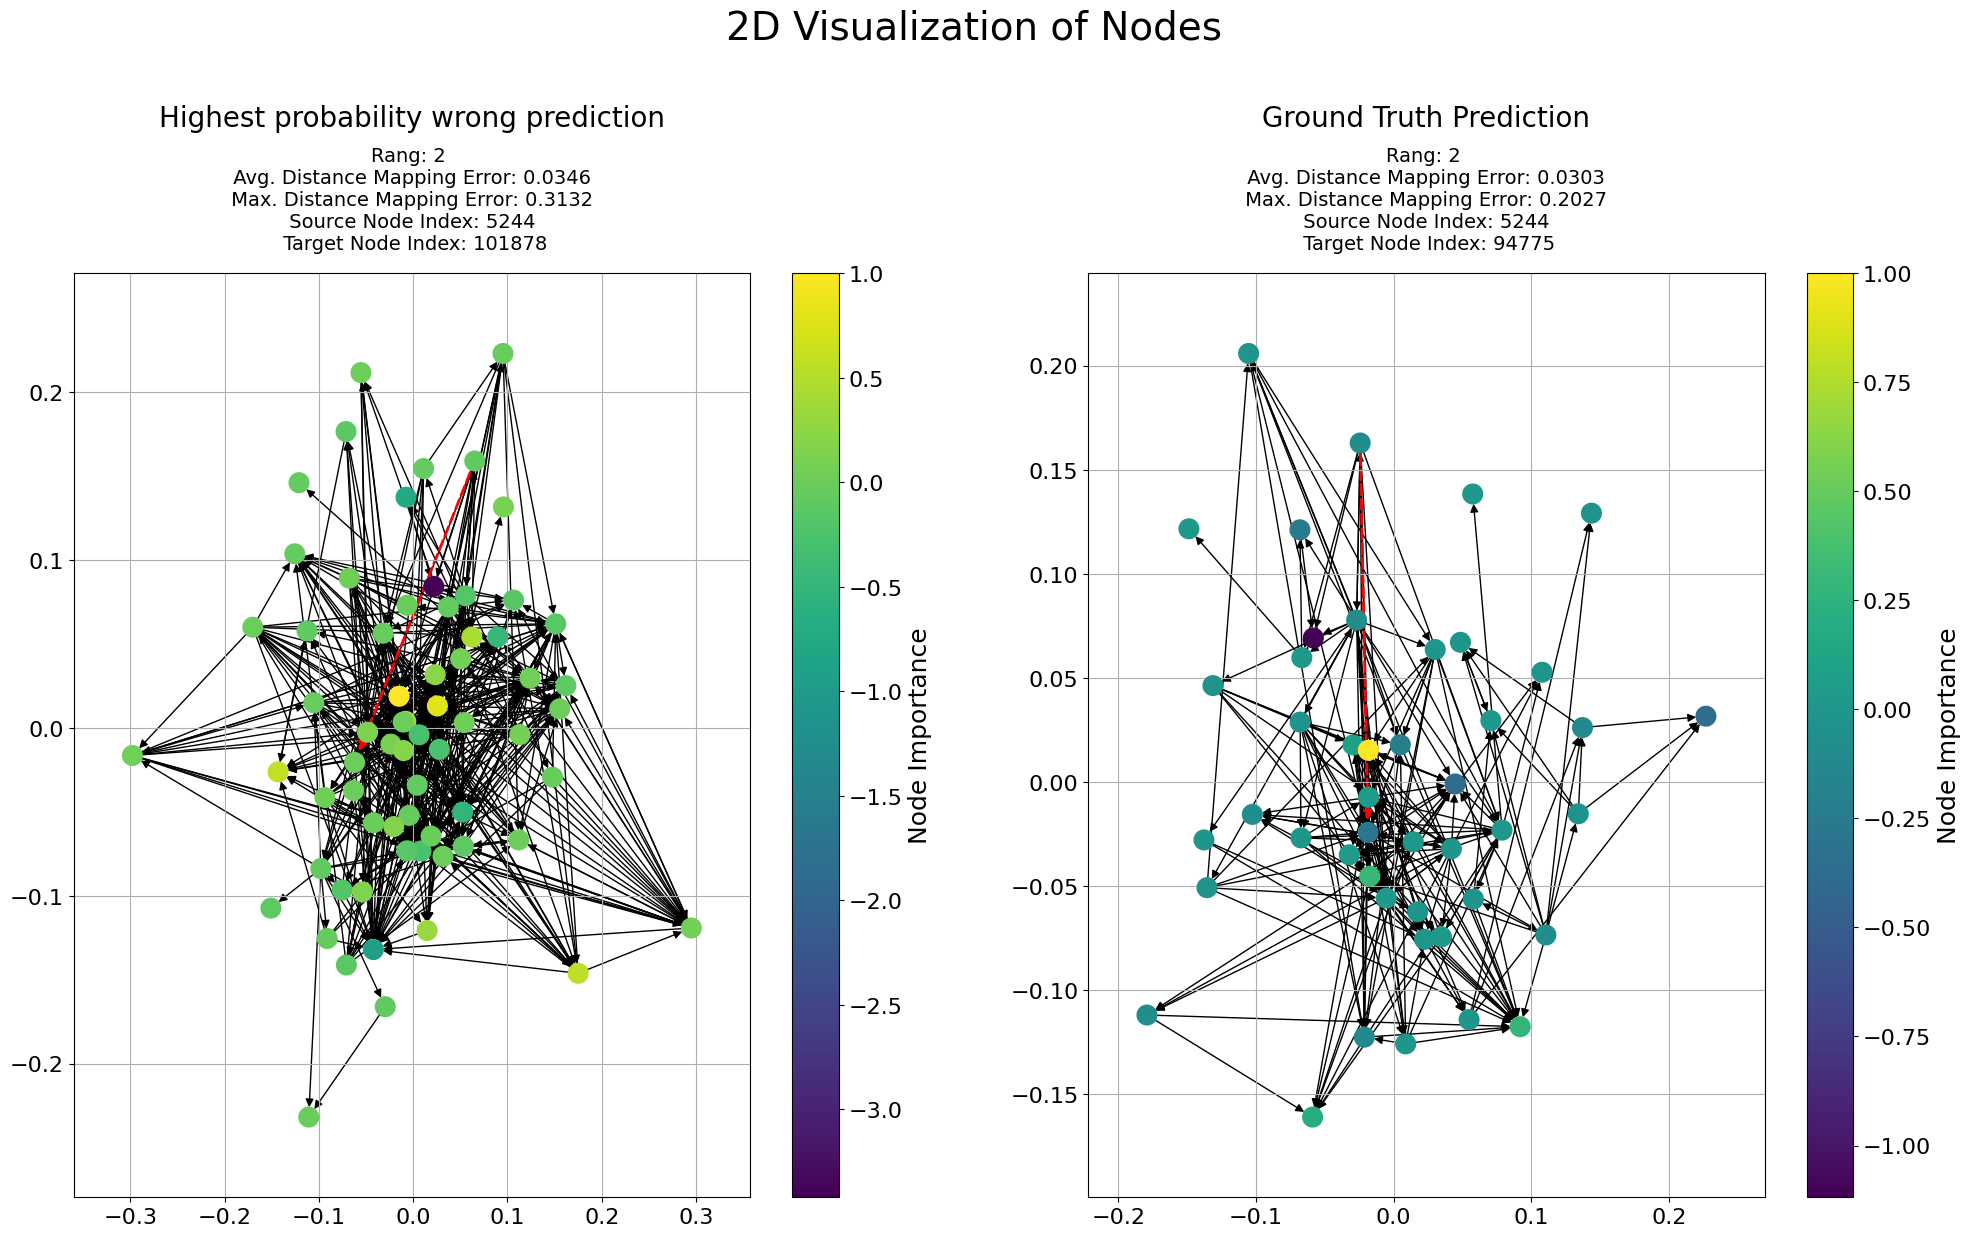

In [65]:
calculate_and_visualize_computational_graph(source_node,graph,mrr_list_val,adj_t,one_hopp=False)

In [26]:
embedding = model(torch.tensor(graph["node_feat"]),adj_t)
predictor(embedding[129762],embedding[44798])

tensor([0.9835], grad_fn=<SigmoidBackward0>)